<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter3/Preprocessing.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install -U tsfresh workalendar astral "featuretools[tsfresh]" sktime

In [2]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Transformations

In [3]:
import numpy as np

np.random.seed(0)
pts = 10000
vals = np.random.lognormal(0, 1.0, pts)

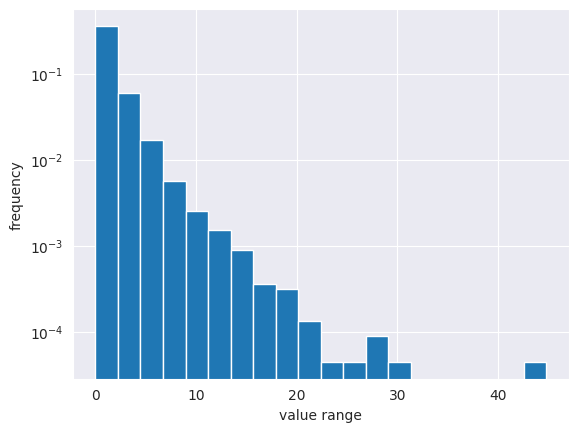

In [4]:
plt.hist(vals, bins=20, density=True)
plt.yscale("log")
plt.ylabel("frequency")
plt.xlabel("value range");

In [5]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest

vals_mm = minmax_scale(vals)
scaler = StandardScaler()
vals_ss = scaler.fit_transform(vals.reshape(-1, 1))
_, p = normaltest(vals_ss.squeeze())
print(f"significance: {p:.2f}")

significance: 0.00


In [6]:
_, p = normaltest(vals_mm.squeeze())
print(f"significance: {p:.2f}")

significance: 0.00


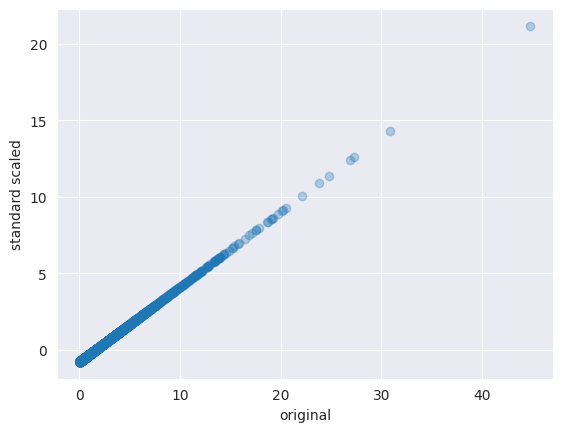

In [7]:
plt.scatter(vals, vals_ss, alpha=0.3)
plt.ylabel("standard scaled")
plt.xlabel("original");

In [8]:
from statsmodels.stats.diagnostic import kstest_normal

log_transformed = np.log(vals)
_, p = kstest_normal(log_transformed)  # stats.normaltest
print(f"significance: {p:.2f}")

significance: 0.31


In [9]:
np.std(log_transformed)

0.9875565681761207

In [10]:
np.mean(log_transformed)

-0.01843372015826582

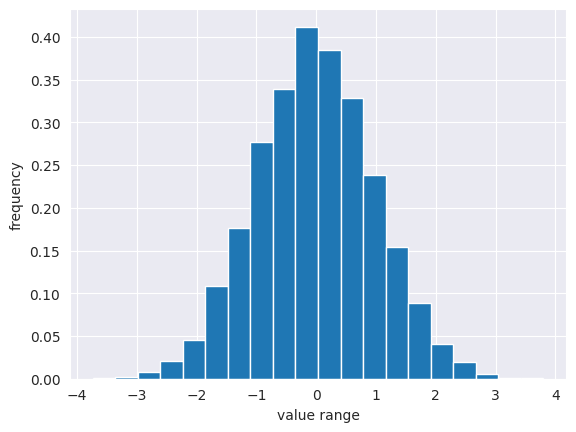

In [11]:
plt.hist(log_transformed, bins=20, density=True)
#plt.yscale("log")
plt.ylabel("frequency")
plt.xlabel("value range");

In [12]:
from scipy.stats import boxcox
vals_bc = boxcox(vals, 0.0)
_, p = normaltest(vals_bc)
print(f"significance: {p:.2f}")

significance: 0.46


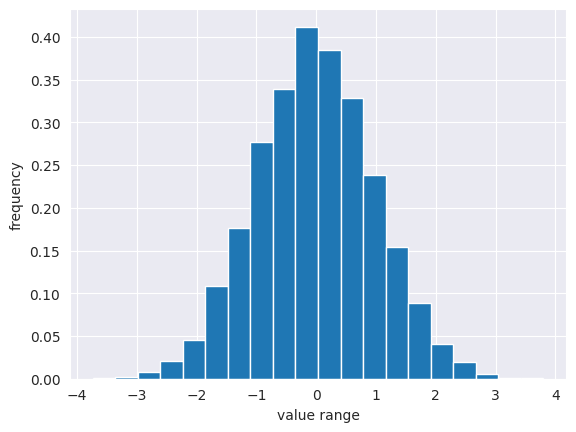

In [13]:
plt.hist(vals_bc, bins=20, density=True)
plt.ylabel("frequency")
plt.xlabel("value range");

# Imputation

In [14]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])
SimpleImputer()
df = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
print(imp_mean.transform(df))


[[ 7.   2.   3. ]
 [ 4.   3.5  6. ]
 [10.   3.5  9. ]]


# Derived Date Features

## Holidays

In [15]:
from workalendar.europe.united_kingdom import UnitedKingdom
UnitedKingdom().holidays()

[(datetime.date(2025, 1, 1), 'New year'),
 (datetime.date(2025, 4, 18), 'Good Friday'),
 (datetime.date(2025, 4, 20), 'Easter Sunday'),
 (datetime.date(2025, 4, 21), 'Easter Monday'),
 (datetime.date(2025, 5, 5), 'Early May Bank Holiday'),
 (datetime.date(2025, 5, 26), 'Spring Bank Holiday'),
 (datetime.date(2025, 8, 25), 'Late Summer Bank Holiday'),
 (datetime.date(2025, 12, 25), 'Christmas Day'),
 (datetime.date(2025, 12, 26), 'Boxing Day')]

In [16]:
from typing import List
from dateutil.relativedelta import relativedelta, TH
import datetime
from workalendar.usa import California

def create_custom_holidays(year) -> List:
      custom_holidays = California().holidays()
      custom_holidays.append((
        (datetime.datetime(year, 11, 1) + relativedelta(weekday=TH(+4)) + datetime.timedelta(days=1)).date(),
        "Black Friday"
      ))
      return {k: v for (k, v) in custom_holidays}

custom_holidays = create_custom_holidays(2021)

In [17]:
custom_holidays

{datetime.date(2025, 1, 1): 'New year',
 datetime.date(2025, 1, 20): 'Birthday of Martin Luther King, Jr.',
 datetime.date(2025, 2, 17): "Washington's Birthday",
 datetime.date(2025, 3, 31): 'Cesar Chavez Day',
 datetime.date(2025, 5, 26): 'Memorial Day',
 datetime.date(2025, 7, 4): 'Independence Day',
 datetime.date(2025, 9, 1): 'Labor Day',
 datetime.date(2025, 11, 11): 'Veterans Day',
 datetime.date(2025, 11, 27): 'Thanksgiving Day',
 datetime.date(2025, 11, 28): 'Thanksgiving Friday',
 datetime.date(2025, 12, 25): 'Christmas Day',
 datetime.date(2021, 11, 26): 'Black Friday'}

In [18]:
def is_holiday(current_date: datetime.date):
    """Determine if we have a holiday."""
    return custom_holidays.get(current_date, False)

today = datetime.date(2021, 4, 11)
is_holiday(today)

False

## Date Annotations

In [19]:
import calendar

calendar.monthrange(2021, 1)

(calendar.FRIDAY, 31)

In [20]:
from datetime import date
def year_anchor(current_date: datetime.date):
      return (
        (current_date - date(current_date.year, 1, 1)).days,
        (date(current_date.year, 12, 31) - current_date).days,
      )

year_anchor(today)


(100, 264)

In [21]:
def month_anchor(current_date: datetime.date):
      last_day = calendar.monthrange(current_date.year, current_date.month)[0]
    
      return (
        (current_date - datetime.date(current_date.year, current_date.month, 1)).days,
        (current_date - datetime.date(current_date.year, current_date.month, last_day)).days,
      )

month_anchor(today)


(10, 8)

## Paydays

In [22]:
def get_last_friday(current_date: datetime.date, weekday=calendar.FRIDAY):
      return max(week[weekday]
        for week in calendar.monthcalendar(
            current_date.year, current_date.month
        ))

get_last_friday(today)


30

## Seasons

In [23]:
YEAR = 2021
seasons = [
    ('winter', (date(YEAR,  1,  1),  date(YEAR,  3, 20))),
    ('spring', (date(YEAR,  3, 21),  date(YEAR,  6, 20))),
    ('summer', (date(YEAR,  6, 21),  date(YEAR,  9, 22))),
    ('autumn', (date(YEAR,  9, 23),  date(YEAR, 12, 20))),
    ('winter', (date(YEAR, 12, 21),  date(YEAR, 12, 31)))
]

def is_in_interval(current_date: datetime.date, seasons):
      return next(season for season, (start, end) in seasons
                if start <= current_date.replace(year=YEAR) <= end)
    
is_in_interval(today, seasons)


'spring'

## Sun and Moon

In [24]:
!pip install astral

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [25]:
from astral.sun import sun
from astral import LocationInfo
CITY = LocationInfo("London", "England", "Europe/London", 51.5, -0.116)
def get_sunrise_dusk(current_date: datetime.date, city_name='London'):
      s = sun(CITY.observer, date=current_date)
      sunrise = s['sunrise']
      dusk = s['dusk']
      return (sunrise - dusk).seconds / 3600

get_sunrise_dusk(today)


9.788055555555555

## Business Days

In [26]:
def get_business_days(current_date: datetime.date):
      last_day = calendar.monthrange(current_date.year, current_date.month)[1]
      rng = pd.date_range(current_date.replace(day=1), periods=last_day, freq='D')
      business_days = pd.bdate_range(rng[0], rng[-1])
      return len(business_days), last_day - len(business_days)

get_business_days(date.today())


(22, 9)

# Automated Feature Extraction

In [27]:
import featuretools as ft
from featuretools.primitives import Minute, Hour, Day, Month, Year, Weekday

data = pd.DataFrame(
    {'Time': ['2014-01-01 01:41:50',
              '2014-01-01 02:06:50',
              '2014-01-01 02:31:50',
              '2014-01-01 02:56:50',
              '2014-01-01 03:21:50'],
     'Target': [0, 0, 0, 0, 1]}
)        
data['index'] = data.index
es = ft.EntitySet('My EntitySet')
es = es.add_dataframe(
    dataframe_name='main_data_table',
    dataframe=data,
    index='index',
    time_index='Time'
)

fm, features = ft.dfs(
    entityset=es, 
    target_dataframe_name='main_data_table',
    trans_primitives=[Minute, Hour, Day, Month, Year, Weekday]
)



/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/featuretools/synthesis/deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


In [28]:
fm

,Target,DAY(Time),HOUR(Time),MINUTE(Time),MONTH(Time),WEEKDAY(Time),YEAR(Time)
index,,,,,,,
0,0,1,1,41,1,2,2014
1,0,1,2,6,1,2,2014
2,0,1,2,31,1,2,2014
3,0,1,2,56,1,2,2014
4,1,1,3,21,1,2,2014


In [29]:
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

settings = ComprehensiveFCParameters()
extract_features(data, column_id='Time', default_fc_parameters=settings)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 189.44it/s]


,Target__variance_larger_than_standard_deviation,Target__has_duplicate_max,Target__has_duplicate_min,Target__has_duplicate,Target__sum_values,Target__abs_energy,Target__mean_abs_change,Target__mean_change,Target__mean_second_derivative_central,Target__median,...,index__fourier_entropy__bins_5,index__fourier_entropy__bins_10,index__fourier_entropy__bins_100,index__permutation_entropy__dimension_3__tau_1,index__permutation_entropy__dimension_4__tau_1,index__permutation_entropy__dimension_5__tau_1,index__permutation_entropy__dimension_6__tau_1,index__permutation_entropy__dimension_7__tau_1,index__query_similarity_count__query_None__threshold_0.0,index__mean_n_absolute_max__number_of_maxima_7
2014-01-01 01:41:50,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 02:06:50,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 02:31:50,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 02:56:50,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 03:21:50,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ROCKET

In [30]:
from sktime.datasets import load_arrow_head
from sktime.datatypes._panel._convert import from_nested_to_2d_array
# Remarque : ce chemin est interne et peut changer dans de futures versions

X_train, y_train = load_arrow_head(split="train", return_X_y=True)
from_nested_to_2d_array(X_train).head()


,dim_0__0,dim_0__1,dim_0__2,dim_0__3,dim_0__4,dim_0__5,dim_0__6,dim_0__7,dim_0__8,dim_0__9,...,dim_0__241,dim_0__242,dim_0__243,dim_0__244,dim_0__245,dim_0__246,dim_0__247,dim_0__248,dim_0__249,dim_0__250
0,-1.963009,-1.957825,-1.956145,-1.938289,-1.896657,-1.869857,-1.838705,-1.812289,-1.736433,-1.673329,...,-1.583857,-1.655329,-1.719153,-1.750881,-1.796273,-1.841345,-1.884289,-1.905393,-1.923905,-1.909153
1,-1.774571,-1.774036,-1.776586,-1.730749,-1.696268,-1.657377,-1.636227,-1.609807,-1.543439,-1.486174,...,-1.471688,-1.484666,-1.539972,-1.590150,-1.635663,-1.639989,-1.678683,-1.729227,-1.775670,-1.789324
2,-1.866021,-1.841991,-1.835025,-1.811902,-1.764390,-1.707687,-1.648280,-1.582643,-1.531502,-1.493609,...,-1.584132,-1.652337,-1.684565,-1.743972,-1.799117,-1.829069,-1.875828,-1.862512,-1.863368,-1.846493
3,-2.073758,-2.073301,-2.044607,-2.038346,-1.959043,-1.874494,-1.805619,-1.731043,-1.712653,-1.628022,...,-1.678942,-1.743732,-1.819801,-1.858136,-1.886146,-1.951247,-2.012927,-2.026963,-2.073405,-2.075292
4,-1.746255,-1.741263,-1.722741,-1.698640,-1.677223,-1.630356,-1.579440,-1.551225,-1.473980,-1.459377,...,-1.547111,-1.607101,-1.635137,-1.686346,-1.691274,-1.716886,-1.740726,-1.743442,-1.762729,-1.763428


In [31]:
from sktime.transformations.panel.rocket import Rocket
rocket = Rocket(num_kernels=1000)
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)


## Shapelets

In [ ]:
from sktime.datasets import load_arrow_head
from sktime.transformations.panel.shapelet_transform import ShapeletTransformPyts

X_train, y_train = load_arrow_head(split="train", return_X_y=True)

shapelets_transform = ShapeletTransformPyts(
    n_shapelets=10,
    criterion="mutual_info",
    window_sizes="auto",
    random_state=42,
    verbose=0
)

shapelets_transform.fit(X_train, y_train)
X_transformed = shapelets_transform.transform(X_train)


In [ ]:
X_train_transform = shapelets_transform.transform(X_train)

In [ ]:
X_train_transform